# CCPA preprocessing

This notebook converts CCPA grib2 files into h5 format

* `$camp_dir/CCPA/CCPA_y{}.hdf`
* `$camp_dir/CCPA/CCPA_lead_y{}.hdf`

In [ ]:
import os
import sys
import time
import h5py
#import pygrib

import numpy as np
#import netCDF4 as nc
from glob import glob

from datetime import datetime, timedelta

In [12]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
    lon_CCPA = h5io['lon_CCPA'][...]
    lat_CCPA = h5io['lat_CCPA'][...]

grid_shape = lon_CCPA.shape

## The original 6-hr 1/8 degree CCPA

In [9]:
hours = ['00', '06', '12', '18']
filename = camp_dir+'wget_CCPA/ccpa.{}/{}/*06h*'

for year in range(2002, 2024, 1):
    if year % 4 == 0:
        N_days = 366
    else:
        N_days = 365

    APCP = np.empty((N_days, 4,)+lon_CCPA.shape)
    APCP[...] = np.nan
    
    base = datetime(year, 1, 1)
    date_list = [base + timedelta(days=d) for d in range(N_days)]
    
    for d, dt in enumerate(date_list):
        for ih, h in enumerate(hours):
            dt_str = datetime.strftime(dt, '%Y%m%d')
            filename_ = glob(filename.format(dt_str, h))
    
            if len(filename_) > 0:
                with pygrib.open(filename_[0]) as grbio:
                    apcp = grbio[1].values
                    apcp = np.array(apcp)
                    apcp[apcp>1000] = 0.0
                    
                APCP[d, ih, ...] = apcp
    
    # tuple_save = (APCP,)
    # label_save = ['CCPA',]
    # du.save_hdf5(tuple_save, label_save, camp_dir+'CCPA/', 
    #              'CCPA_y{}.hdf'.format(year))

## Convert CCPA to forecast lead time versions

In [10]:
LEADs = np.arange(6, 144+6, 6, dtype=int)
N_lead = len(LEADs)
filename_ccpa = camp_dir+'CCPA/CCPA_y{}.hdf'

In [1]:
for year in range(2020, 2022):

    if year % 4 == 0:
        N_days = 366
    else:
        N_days = 365
    
    
    with h5py.File(filename_ccpa.format(year), 'r') as h5io:
        CCPA_base = h5io['CCPA'][...]
    L_base = len(CCPA_base)
    
    # forecast lead times can exceed one year
    N_beyond = 10
    N_total = L_base + N_beyond
    with h5py.File(filename_ccpa.format(year+1), 'r') as h5io:
        CCPA_extra = h5io['CCPA'][:N_beyond, ...]
    
    CCPA = np.concatenate((CCPA_base, CCPA_extra), axis=0)
    
    CCPA_lead = np.empty((N_days, N_lead)+grid_shape)
    CCPA_lead[...] = np.nan
    
    for d in range(N_days):
        for ilead, lead in enumerate(LEADs):
            d_ = lead // 24
            day = d + d_
            ind_hour = lead % 24
            ind_hour = int(ind_hour/6)
            
            CCPA_lead[d, ilead, ...] = CCPA[day, ind_hour, ...]
    
    # tuple_save = (CCPA_lead,)
    # label_save = ['CCPA_lead',]
    # du.save_hdf5(tuple_save, label_save, camp_dir+'CCPA/', 'CCPA_lead_y{}.hdf'.format(year))

### Check that the lead time verision is correct

* initialization at day 0, 138-144hr forecast
* initialization at day 5, 18-24hr forecast

They should have the same CCA obs 

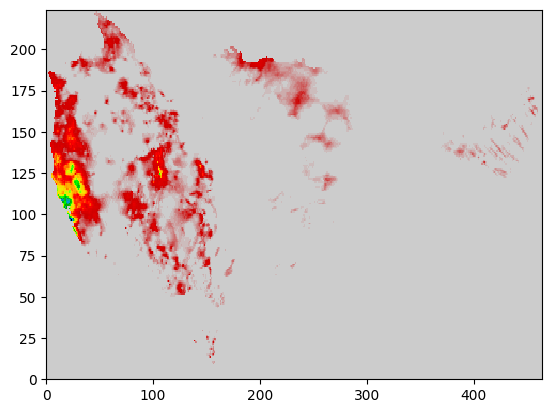

In [27]:
plt.pcolormesh(CCPA_lead[5, 3, ...], cmap=plt.cm.nipy_spectral_r)

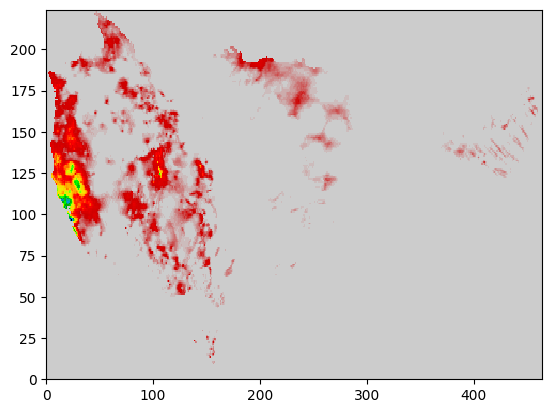

In [19]:
plt.pcolormesh(CCPA_lead[0, 23, ...], cmap=plt.cm.nipy_spectral_r)